In [1]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [2]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [3]:
N_YEARS = 50
N_CUTS = 10
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = '1996-01-01' #str(TODAY - timedelta(N_DAYS))
START, TODAY

('1996-01-01', datetime.date(2022, 2, 27))

[0.46566129 0.2213282  0.10519701 0.05       0.02376493 0.01129544
 0.00536871]


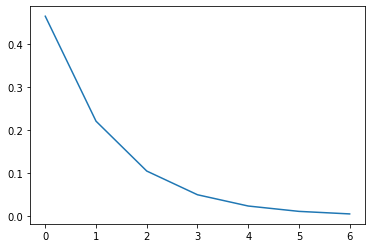

In [4]:
SDS = 0.05 * (0.8 ** np.linspace(-10, 10, 7))
print(SDS)
plt.plot(SDS);

In [5]:
SD = SDS[TODAY.weekday()]
SD

0.005368709120000003

In [6]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMD', 'AMZN', 'ANET', 'APPH', 'AXON',
    'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG', 'DKNG',
    'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'FUV', 'FVRR', 'GH', 'GMED',
    'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD', 'LULU','MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW',
    'PINS', 'PTON', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE',
    'SOLO', 'SPLK', 'SQ', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO',
    'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA',  # NY Stock Exchange (total)
           '^W5000'] # Wilshire 5k
len(SYMBOLS)

67

In [7]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [8]:
#batch = SYMBOLS + INDICES # run all
batch = INDICES
stock_loader = Loader(batch, START, str(TODAY), verbose=True)
data = stock_loader.download()

[*********************100%***********************]  4 of 4 completed
Generating derived columns...
   ...^GSPC
   ...^IXIC
   ...^NYA
   ...^W5000


In [9]:
data['Date'].tail()

6580   2022-02-18
6581   2022-02-22
6582   2022-02-23
6583   2022-02-24
6584   2022-02-25
Name: Date, dtype: datetime64[ns]

In [10]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [11]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [12]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(f'Unexpected error getting {stock} data. '
              'Initialized as None.')

In [13]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [14]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best.json', 'w') as f:
        json.dump(best_param_set, f)




----------------------------------------------------------------------
                                 ^GSPC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 3.907400008115249
Refitting current best...
Current best ma returns: 4.197256187593715
Fraction Invested: 0.9607454308175882
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 4.197256359472272
Invested: 0.9607454308175882
New best: 4.197289780899294
Invested: 0.9607454308175882
New best: 4.197289824532245
Invested: 0.9607454308175882
Round: 30


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 3.907400008115249
Refitting current best...
Current best ew_ma returns: 4.127543599304234
Fraction Invested: 0.9743898367843051
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 30


Beginning rel_minmax m

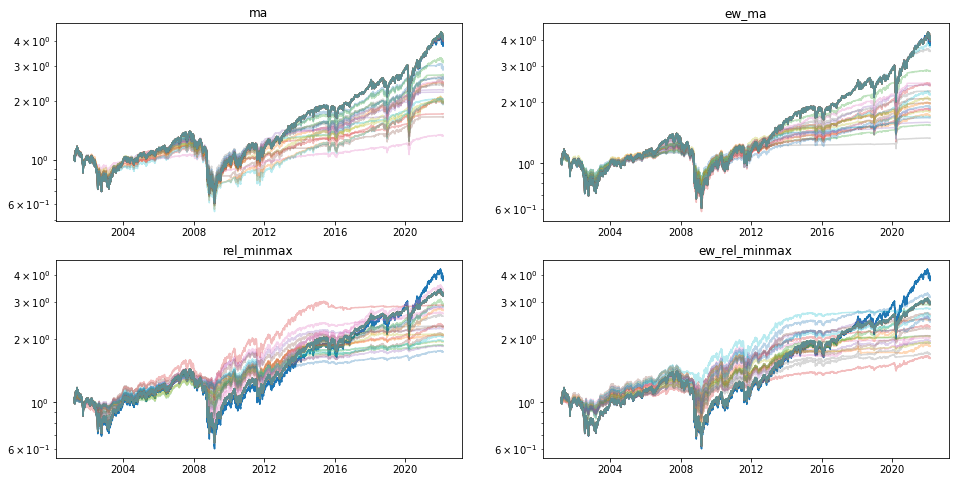

Saving ^GSPC params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 7.482458632701502
Refitting current best...
Current best ma returns: 9.076291200608294
Fraction Invested: 0.9999897367110886
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 30


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 7.482458632701502
Refitting current best...
Current best ew_ma returns: 9.420408794611273
Fraction Invested: 0.9981724148244561
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 30


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 7.482458632701502
Refitting current best...
Fraction Invested: 1
Beg

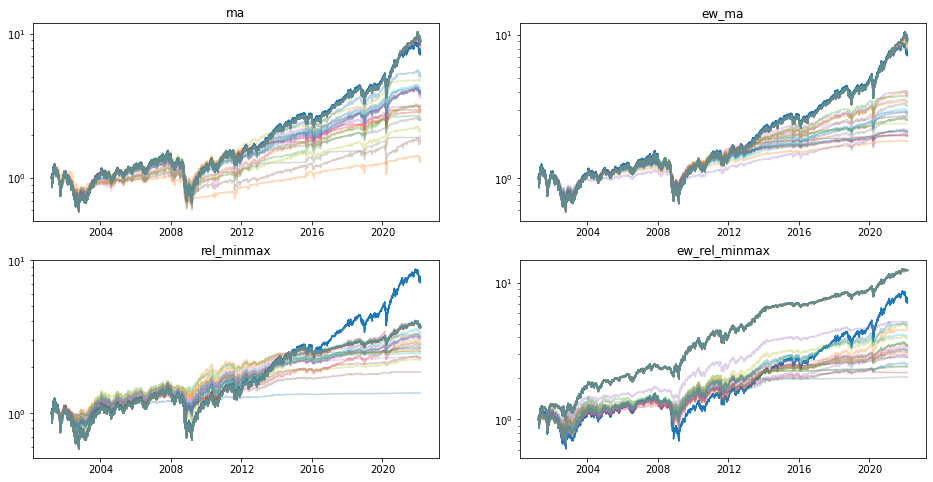

Saving ^IXIC params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.7013541752143335
Refitting current best...
Current best ma returns: 3.4247353266852683
Fraction Invested: 0.9999999998715677
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 30


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 2.7013541752143335
Refitting current best...
Current best ew_ma returns: 2.9564330868294113
Fraction Invested: 0.5907402534402694
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 2.956711616666224
Invested: 0.5907402534402694
New best: 2.9568454277697933
Invested: 0.5907402534402694
Round: 30


Beginning rel_minmax method...
---------------------

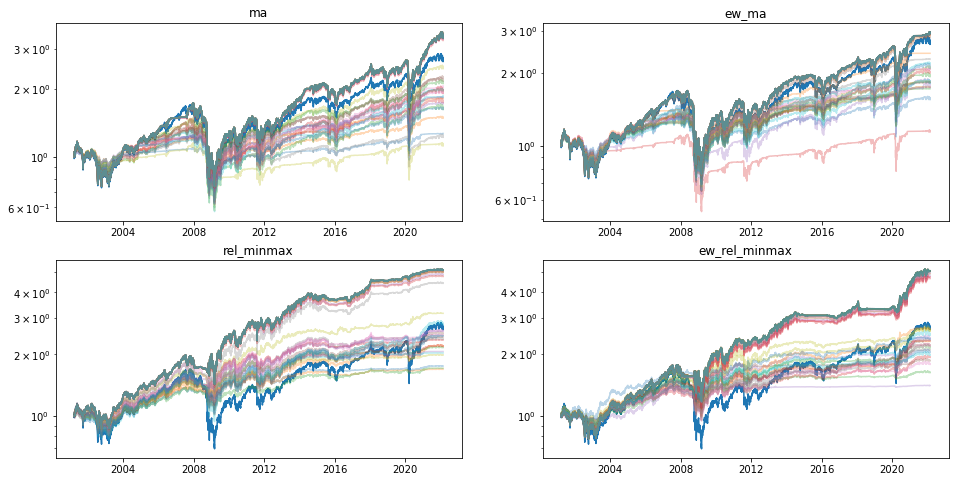

Saving ^NYA params...



----------------------------------------------------------------------
                                 ^W5000
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 4.2936266842747965
Refitting current best...
Current best ma returns: 4.6290349096622885
Fraction Invested: 0.9942055815692069
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 30


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 4.2936266842747965
Refitting current best...
Current best ew_ma returns: 4.680334437286422
Fraction Invested: 0.9956695278689802
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 4.682409608471003
Invested: 0.9956695278689802
Round: 30


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 4.293626

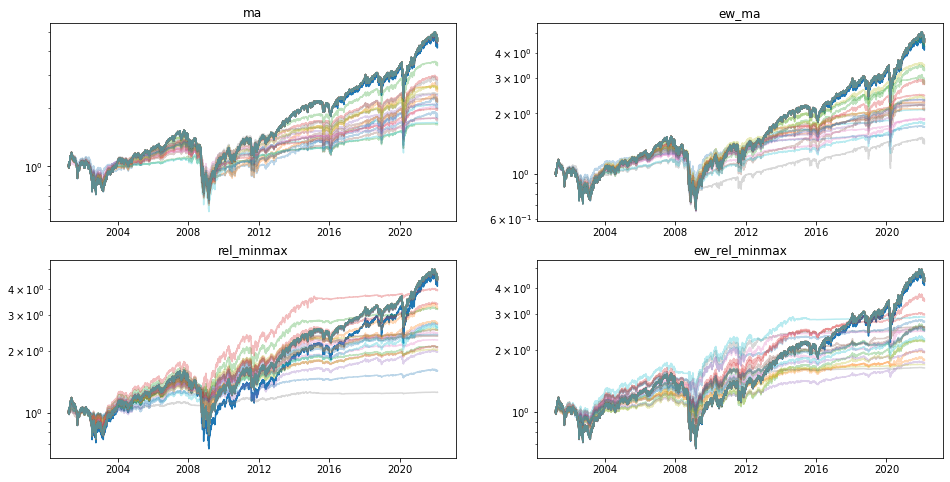

Saving ^W5000 params...


In [66]:
N_RAND = 20
N_ADJ = 30

for stock in batch:
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(stock_data, 
                      N_CUTS, 
                      best_param_set=best_params, 
                      best_returns=best_returns, 
                      sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [67]:
def get_summary(stocks):
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {100 * best_pct:.2f}% in')
            data = best[best_method]
            print('time param:', data['time_param'])
            print('qs:')
            for rng, pct in data['q_params'].items():
                lower, upper = [float(x) for x in rng[1:-1].split(', ')]
                print(f'({lower:.3f} - {upper:.3f}): {pct:.3f}')
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue

In [68]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
get_summary(batch)


^GSPC:
  Best Return: 4.197289824532245 (ma)
  96.07% in
time param: 1079
qs:
(0.000 - 0.049): 1.000
(0.049 - 0.492): 1.000
(0.492 - 0.503): 1.000
(0.503 - 0.556): 1.000
(0.556 - 0.572): 1.000
(0.572 - 0.593): 0.961
(0.593 - 0.652): 0.961
(0.652 - 0.981): 0.961
(0.981 - 0.985): 0.001
(0.985 - 1.000): 0.000

^IXIC:
  Best Return: 12.4830982710707 (ew_rel_minmax)
  7.48% in
time param: 1242
qs:
(0.000 - 0.353): 0.999
(0.353 - 0.392): 0.999
(0.392 - 0.412): 0.820
(0.412 - 0.453): 0.819
(0.453 - 0.475): 0.675
(0.475 - 0.486): 0.668
(0.486 - 0.494): 0.342
(0.494 - 0.515): 0.323
(0.515 - 0.986): 0.323
(0.986 - 1.000): 0.075

^NYA:
  Best Return: 5.142448903867856 (rel_minmax)
  14.75% in
time param: 390
qs:
(0.000 - 0.685): 1.000
(0.685 - 0.699): 0.997
(0.699 - 0.727): 0.997
(0.727 - 0.741): 0.997
(0.741 - 0.741): 0.843
(0.741 - 0.750): 0.148
(0.750 - 0.789): 0.147
(0.789 - 0.990): 0.147
(0.990 - 0.995): 0.147
(0.995 - 1.000): 0.000

^W5000:
  Best Return: 4.682409608471003 (ew_ma)
  99.57%

In [69]:
!say qp is dunzo

IXIC: Nasdaq